January 27, 2026

##### Model 4 Changes (from Model 3):

**Critical Bug Fix:**
- Fixed patient indexing bug in dataset that caused 12% of validation samples to fail

**New Features:**
- Multi-class segmentation (4 classes: Background, NCR/NET, Edema, Enhancing Tumor)
- Includes slices WITHOUT tumors (model learns when there's no tumor)
- Data augmentation: rotation (±15°) and horizontal flip
- Multi-class Dice Loss with per-class tracking
- Modified U-Net to support variable number of output classes

**Still Using:**
- Single modality (T1ce only) - Multi-modality will be Model 5
- 2D slices - 3D model will be Model 6

# The Data Pipeline: 3D .nii file -> 2D image -> torch tensors

In [1]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# NEW FOR MODEL 4: Import the new multi-class dataset
from brats_utils import BraTSMultiClassDataset

DATA_ROOT = Path("/Users/michaelbanks/Desktop/AI TXG/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")

# NEW FOR MODEL 4: Using BraTSMultiClassDataset with augmentation enabled for training
train_dataset = BraTSMultiClassDataset(DATA_ROOT, 0, 200, augment=True)

# Validation and test do NOT use augmentation
validation_dataset = BraTSMultiClassDataset(DATA_ROOT, 200, 300, augment=False)

test_dataset = BraTSMultiClassDataset(DATA_ROOT, 300, 369, augment=False)

Preprocessing: Scanning for ALL slices with brain tissue...
Success! Found 26156 valid slices with brain tissue.
  → 13241 slices with tumor (50.6%)
  → 12915 slices without tumor (49.4%)
Preprocessing: Scanning for ALL slices with brain tissue...
Success! Found 13051 valid slices with brain tissue.
  → 6545 slices with tumor (50.1%)
  → 6506 slices without tumor (49.9%)
Preprocessing: Scanning for ALL slices with brain tissue...
Success! Found 8890 valid slices with brain tissue.
  → 4579 slices with tumor (51.5%)
  → 4311 slices without tumor (48.5%)


##### Quick Data Visualization

Image Shape: torch.Size([1, 240, 240])
Mask Shape: torch.Size([240, 240])
Mask dtype: torch.int64
Unique labels in mask: tensor([0])


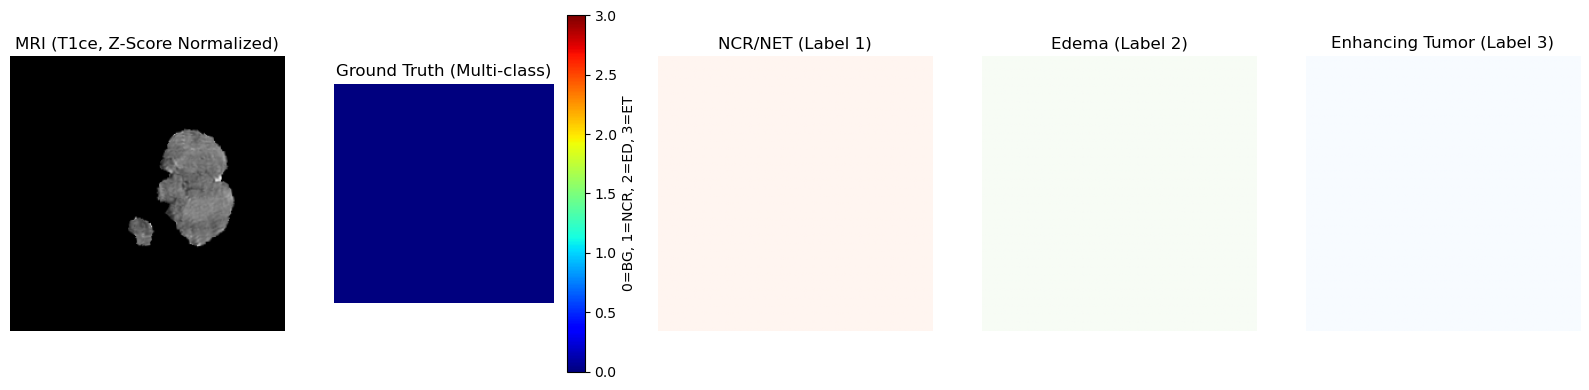

In [2]:
if len(train_dataset) > 0:
    sample_img, sample_mask = train_dataset[16] 

    print(f"Image Shape: {sample_img.shape}")  # Expect: (1, 240, 240)
    print(f"Mask Shape: {sample_mask.shape}")  # NEW: Expect (240, 240) not (1, 240, 240)
    print(f"Mask dtype: {sample_mask.dtype}")  # NEW: Expect torch.int64 (long) not float
    print(f"Unique labels in mask: {torch.unique(sample_mask)}")  # NEW: Should see 0, 1, 2, 3

    def visualize_multiclass(img_tensor, mask_tensor):
        """NEW FOR MODEL 4: Visualize multi-class mask with different colors"""
        img = img_tensor.squeeze().numpy()
        mask = mask_tensor.numpy()
        
        plt.figure(figsize=(16, 4))
        
        plt.subplot(1, 5, 1)
        plt.imshow(img, cmap='gray')
        plt.title("MRI (T1ce, Z-Score Normalized)")
        plt.axis('off')
        
        plt.subplot(1, 5, 2)
        plt.imshow(mask, cmap='jet', vmin=0, vmax=3)
        plt.title("Ground Truth (Multi-class)")
        plt.colorbar(label="0=BG, 1=NCR, 2=ED, 3=ET")
        plt.axis('off')
        
        # Show each class separately
        plt.subplot(1, 5, 3)
        plt.imshow((mask == 1).astype(float), cmap='Reds')
        plt.title("NCR/NET (Label 1)")
        plt.axis('off')
        
        plt.subplot(1, 5, 4)
        plt.imshow((mask == 2).astype(float), cmap='Greens')
        plt.title("Edema (Label 2)")
        plt.axis('off')
        
        plt.subplot(1, 5, 5)
        plt.imshow((mask == 3).astype(float), cmap='Blues')
        plt.title("Enhancing Tumor (Label 3)")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

    visualize_multiclass(sample_img, sample_mask)
else:
    print("ERROR: Dataset is empty. Please check the data path.")

##### The DataLoader

In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

batch_imgs, batch_masks = next(iter(train_dataloader))

print(f"Batch of Images Shape: {batch_imgs.shape}")  # (16, 1, 240, 240)
print(f"Batch of Masks Shape:  {batch_masks.shape}")  # NEW: (16, 240, 240) not (16, 1, 240, 240)

ValueError: At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. (You can probably work around this by making a copy of your array  with array.copy().) 

# The Model: U-NET (Modified for Multi-Class)

In [ ]:
import torch.nn as nn

class SimpleUNet(nn.Module):
    """
    MODIFIED FOR MODEL 4: Added num_classes parameter
    
    Now supports multi-class output by changing the final convolutional layer
    to output num_classes channels instead of always outputting 1.
    """
    def __init__(self, num_classes=1):  # NEW: num_classes parameter (default=1 for backward compatibility)
        super().__init__()
        
        # Encoder (same as Model 3)
        self.enc1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.Conv2d(16, 16, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2, 2) # 240 -> 120
        
        self.enc2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.Conv2d(32, 32, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2, 2) # 120 -> 60
        
        self.enc3 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool3 = nn.MaxPool2d(2, 2) # 60 -> 30

        # Bottleneck (same as Model 3)
        self.bottleneck = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        # Decoder (same as Model 3)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) 
        self.dec3 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU()) 

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) 
        self.dec2 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1), nn.ReLU()) 

        self.up1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2) 
        self.dec1 = nn.Sequential(nn.Conv2d(32, 16, 3, padding=1), nn.ReLU()) 

        # NEW FOR MODEL 4: Final layer now outputs num_classes channels instead of 1
        self.final = nn.Conv2d(16, num_classes, kernel_size=1)
        
        # NEW FOR MODEL 4: No sigmoid! For multi-class we'll use softmax (applied in loss function)
        # (We could add softmax here, but it's more efficient to use it inside the loss)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        
        # Bottleneck
        b = self.bottleneck(self.pool3(e3))
        
        # Decoder with skip connections
        d3 = self.up3(b)
        d3 = torch.cat((e3, d3), dim=1) 
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat((e2, d2), dim=1) 
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat((e1, d1), dim=1) 
        d1 = self.dec1(d1)
        
        # NEW FOR MODEL 4: Return logits (no sigmoid/softmax applied)
        return self.final(d1)

##### Quick Shape Check

In [ ]:
# NEW FOR MODEL 4: Initialize with num_classes=4
model = SimpleUNet(num_classes=4)

predictions = model(batch_imgs).detach()

print(f"Input Shape:      {batch_imgs.shape}")  # (16, 1, 240, 240)
print(f"Prediction Shape: {predictions.shape}")  # NEW: (16, 4, 240, 240) - 4 classes!
print(f"Mask Shape:       {batch_masks.shape}")  # (16, 240, 240)

# For multi-class, we compare prediction channels to mask classes
print("\nSUCCESS: The model output has 4 channels (one per class). Ready to train!")

##### Set up Device, Loss, and Optimizer

In [ ]:
import torch.optim as optim

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Success: Using Apple Metal (MPS) Acceleration!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Success: Using NVIDIA (CUDA) Acceleration!")
else:
    device = torch.device("cpu")
    print("Using CPU (Slower, but works)")

model = model.to(device)

# NEW FOR MODEL 4: Multi-class Dice Loss
class MultiClassDiceLoss(nn.Module):
    """
    NEW FOR MODEL 4: Dice Loss for multi-class segmentation
    
    Computes Dice score for each class separately, then averages.
    This is the standard approach for multi-class medical image segmentation.
    
    Why Dice Loss for medical images?
    - Handles class imbalance well (tumor is small compared to background)
    - Directly optimizes the metric we care about (overlap)
    - Works better than Cross-Entropy for segmentation
    """
    def __init__(self, num_classes=4, smooth=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth
    
    def forward(self, predictions, targets):
        """
        predictions: (B, C, H, W) logits from model
        targets: (B, H, W) class indices (0, 1, 2, 3)
        """
        # Apply softmax to convert logits to probabilities
        predictions = torch.softmax(predictions, dim=1)  # (B, C, H, W)
        
        # Convert targets to one-hot encoding
        targets_one_hot = torch.zeros_like(predictions)
        targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)  # (B, C, H, W)
        
        # Compute Dice for each class
        dice_scores = []
        for c in range(self.num_classes):
            pred_c = predictions[:, c, :, :]  # (B, H, W)
            target_c = targets_one_hot[:, c, :, :]  # (B, H, W)
            
            intersection = torch.sum(pred_c * target_c)
            union = torch.sum(pred_c) + torch.sum(target_c)
            
            dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
            dice_scores.append(dice)
        
        # Average Dice across all classes
        avg_dice = torch.mean(torch.stack(dice_scores))
        
        # Return loss (1 - Dice, since we want to minimize)
        return 1.0 - avg_dice

criterion = MultiClassDiceLoss(num_classes=4)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# The Training Loop

In [ ]:
from tqdm.auto import tqdm

num_epochs = 10
history = {
    'train_loss': [],
    'val_loss': [],
    'train_dice_per_class': [],  # NEW: Track per-class Dice
    'val_dice_per_class': []     # NEW: Track per-class Dice
}

print("Starting Training...")

# NEW FOR MODEL 4: Helper function to compute per-class Dice
def compute_dice_per_class(predictions, targets, num_classes=4, smooth=1e-6):
    """Compute Dice score for each class separately"""
    predictions = torch.softmax(predictions, dim=1)
    targets_one_hot = torch.zeros_like(predictions)
    targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)
    
    dice_scores = []
    for c in range(num_classes):
        pred_c = predictions[:, c, :, :]
        target_c = targets_one_hot[:, c, :, :]
        
        intersection = torch.sum(pred_c * target_c)
        union = torch.sum(pred_c) + torch.sum(target_c)

        dice = (2.0 * intersection + smooth) / (union + smooth)
        dice_scores.append(dice.item())
    
    return dice_scores

for epoch in range(num_epochs):
    # ==================== TRAINING ====================
    model.train() 
    train_running_loss = 0.0
    train_dice_accumulator = [0.0, 0.0, 0.0, 0.0]  # For 4 classes
    
    for i, (images, masks) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()             
        outputs = model(images)           
        loss = criterion(outputs, masks)  
        loss.backward()                   
        optimizer.step()                  
        
        train_running_loss += loss.item()
        
        # NEW: Track per-class Dice during training
        with torch.no_grad():
            dice_scores = compute_dice_per_class(outputs, masks)
            for c in range(4):
                train_dice_accumulator[c] += dice_scores[c]
    
    # Compute average training metrics
    train_epoch_loss = train_running_loss / len(train_dataloader)
    train_dice_per_class = [score / len(train_dataloader) for score in train_dice_accumulator]
    history['train_loss'].append(train_epoch_loss)
    history['train_dice_per_class'].append(train_dice_per_class)

    # NEW FOR MODEL 4: Print per-class Dice scores
    print(f"\nTrain Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Loss: {train_epoch_loss:.4f}")
    print(f"  Dice per class - BG: {train_dice_per_class[0]:.4f}, NCR: {train_dice_per_class[1]:.4f}, ED: {train_dice_per_class[2]:.4f}, ET: {train_dice_per_class[3]:.4f}")

    # ==================== VALIDATION ====================
    model.eval()
    validation_running_loss = 0.0
    val_dice_accumulator = [0.0, 0.0, 0.0, 0.0]
    
    with torch.no_grad():  # NEW: Better practice to use no_grad for entire validation
        for i, (images, masks) in enumerate(tqdm(validation_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")):
            images = images.to(device)
            masks = masks.to(device)             
            
            outputs = model(images)           
            loss = criterion(outputs, masks)                
            
            validation_running_loss += loss.item()
            
            # Track per-class Dice during validation
            dice_scores = compute_dice_per_class(outputs, masks)
            for c in range(4):
                val_dice_accumulator[c] += dice_scores[c]
    
    # Compute average validation metrics
    validation_epoch_loss = validation_running_loss / len(validation_dataloader)
    val_dice_per_class = [score / len(validation_dataloader) for score in val_dice_accumulator]
    history['val_loss'].append(validation_epoch_loss)
    history['val_dice_per_class'].append(val_dice_per_class)
    
    print(f"Val Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Loss: {validation_epoch_loss:.4f}")
    print(f"  Dice per class - BG: {val_dice_per_class[0]:.4f}, NCR: {val_dice_per_class[1]:.4f}, ED: {val_dice_per_class[2]:.4f}, ET: {val_dice_per_class[3]:.4f}")
    print("-" * 80)

print("Training Finished!")

# Save checkpoints
torch.save(model.state_dict(), 'model4_checkpoint.pth') 
torch.save(optimizer.state_dict(), 'optimizer4_checkpoint.pth')
print("Checkpoints saved!")

# Training History Visualization

In [ ]:
# NEW FOR MODEL 4: Visualize training progress with per-class Dice scores
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Training Dice per class
plt.subplot(1, 3, 2)
train_dice_array = np.array(history['train_dice_per_class'])
for c, label in enumerate(['Background', 'NCR/NET', 'Edema', 'Enhancing']):
    plt.plot(train_dice_array[:, c], label=label)
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Training Dice Score per Class')
plt.legend()
plt.grid(True)

# Validation Dice per class
plt.subplot(1, 3, 3)
val_dice_array = np.array(history['val_dice_per_class'])
for c, label in enumerate(['Background', 'NCR/NET', 'Edema', 'Enhancing']):
    plt.plot(val_dice_array[:, c], label=label)
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Validation Dice Score per Class')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Validation & Visualization

In [ ]:
# Load the trained model
testModel = SimpleUNet(num_classes=4)
testModel.load_state_dict(torch.load('model4_checkpoint.pth', weights_only=True))
testModel = testModel.to(device)
testModel.eval()

In [ ]:
# Test on a sample from validation set
test_img, test_mask = validation_dataset[500] 

input_tensor = test_img.unsqueeze(0).to(device)

with torch.no_grad(): 
    prediction = testModel(input_tensor)
    # NEW: Apply softmax and get class predictions
    prediction_probs = torch.softmax(prediction, dim=1)
    prediction_classes = torch.argmax(prediction_probs, dim=1)

pred_cpu = prediction_classes.squeeze().cpu().numpy()
img_cpu = test_img.squeeze().numpy()
mask_cpu = test_mask.numpy()

plt.figure(figsize=(18, 5))

plt.subplot(1, 6, 1)
plt.imshow(img_cpu, cmap='gray')
plt.title("Original MRI")
plt.axis('off')

plt.subplot(1, 6, 2)
plt.imshow(mask_cpu, cmap='jet', vmin=0, vmax=3)
plt.title("Ground Truth")
plt.colorbar(label="0=BG, 1=NCR, 2=ED, 3=ET")
plt.axis('off')

plt.subplot(1, 6, 3)
plt.imshow(pred_cpu, cmap='jet', vmin=0, vmax=3)
plt.title("Model Prediction")
plt.colorbar(label="0=BG, 1=NCR, 2=ED, 3=ET")
plt.axis('off')

# Show each predicted class separately
plt.subplot(1, 6, 4)
plt.imshow((pred_cpu == 1).astype(float), cmap='Reds')
plt.title("Predicted NCR/NET")
plt.axis('off')

plt.subplot(1, 6, 5)
plt.imshow((pred_cpu == 2).astype(float), cmap='Greens')
plt.title("Predicted Edema")
plt.axis('off')

plt.subplot(1, 6, 6)
plt.imshow((pred_cpu == 3).astype(float), cmap='Blues')
plt.title("Predicted Enhancing")
plt.axis('off')

plt.tight_layout()
plt.show()

# Next Steps for Model 5:

**Primary Goal: Multi-Modality Input**
- Incorporate all 4 MRI modalities (T1, T1ce, T2, FLAIR)
- Modify model input from 1 channel to 4 channels
- Each modality provides unique information about the tumor

**Additional Improvements:**
- Better data preprocessing (intensity normalization across modalities)
- More sophisticated augmentation (elastic deformation, intensity shifts)
- Evaluation using BraTS regions (WT, TC, ET) not just raw labels

**Still for Future (Model 6+):**
- 3D U-Net architecture
- Patch-based training
- Ensemble methods